In [1]:
import os, sys
from pyprojroot.here import here
from tqdm.auto import trange, tqdm

import pandas as pd
import anndata as ad
import numpy as np

import pickle

from collections import defaultdict

import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Import functions
sys.path.insert(1, str(here('bin')))
from customPythonFunctions import generate_shap_data
import anndata as ad

from pyprojroot import here

CELL_TYPES = ['B','Plasma','pDC','DC','Mono','T_CD4_Naive','T_CD4_NonNaive','T_CD8_Naive','T_CD8_NonNaive','UTC','ILC']

### Load SHAP for diseases 

In [2]:
shap_disease_per_cell_type = dict()

In [3]:
for cell_type in  tqdm(CELL_TYPES):
    shap_ct_df = generate_shap_data(
        cell_type = cell_type,
        shap_stats_path = here(f'03_downstream_analysis/08_gene_importance/results/targetY_disease/shap/shap_vals/total_run1_{cell_type}_shap_stats.npz'), 
        adata_path = here(f'03_downstream_analysis/08_gene_importance/data/{cell_type}_adataMerged_SPECTRAgenes.log1p.h5ad'),
        gene_symbol_df_path = here('03_downstream_analysis/02_gene_universe_definition/results/04_selected_gene_list.pkl'),
        stat = 'mean_abs',
        category_col = 'disease',
        expressed_gene_cellTypes_path = here('03_downstream_analysis/08_gene_importance/results/genes_expressing_cells.csv')
    )    
    shap_disease_per_cell_type[cell_type]= shap_ct_df

  0%|          | 0/11 [00:00<?, ?it/s]

### Load SHAP for studies 

In [4]:
shap_study_per_cell_type = dict()

In [5]:
for cell_type in  tqdm(CELL_TYPES):
    shap_ct_df = generate_shap_data(
        cell_type = cell_type,
        shap_stats_path = here(f'03_downstream_analysis/08_gene_importance/results/targetY_studyID/shap/shap_vals/total_studyID_{cell_type}_shap_stats.npz'), 
        adata_path = here(f'03_downstream_analysis/08_gene_importance/data/{cell_type}_adataMerged_SPECTRAgenes.log1p.h5ad'),
        gene_symbol_df_path = here('03_downstream_analysis/02_gene_universe_definition/results/04_selected_gene_list.pkl'),
        stat = 'mean_abs',
        category_col = 'studyID',
        expressed_gene_cellTypes_path = here('03_downstream_analysis/08_gene_importance/results/genes_expressing_cells.csv')
    )    
    shap_study_per_cell_type[cell_type]= shap_ct_df

  0%|          | 0/11 [00:00<?, ?it/s]

In [6]:
## Match study with diseases in it
anndata = ad.read_h5ad(here(f'03_downstream_analysis/08_gene_importance/data/{cell_type}_adataMerged_SPECTRAgenes.log1p.h5ad'), backed = 'r')
anndata.obs[['disease', 'studyID']].drop_duplicates().values
disease_to_study_match = pd.DataFrame({'disease': anndata.obs[['disease', 'studyID']].drop_duplicates().values[:, 0], 'study': anndata.obs[['disease', 'studyID']].drop_duplicates().values[:, 1]})

In [7]:
## Make a dict with the aggregated (by summing up) study SHAPs per gene per disease
study_shap_per_disease = dict()

for cell_type in  tqdm(CELL_TYPES):
    df = shap_study_per_cell_type[cell_type].T
    df['study'] = df.index
    df = df.merge(disease_to_study_match, how = 'left', on = 'study').drop('study', axis=1).groupby(['disease']).sum()

    study_shap_per_disease[cell_type] = df.T

  0%|          | 0/11 [00:00<?, ?it/s]

In [8]:
CELL_TYPES

['B',
 'Plasma',
 'pDC',
 'DC',
 'Mono',
 'T_CD4_Naive',
 'T_CD4_NonNaive',
 'T_CD8_Naive',
 'T_CD8_NonNaive',
 'UTC',
 'ILC']

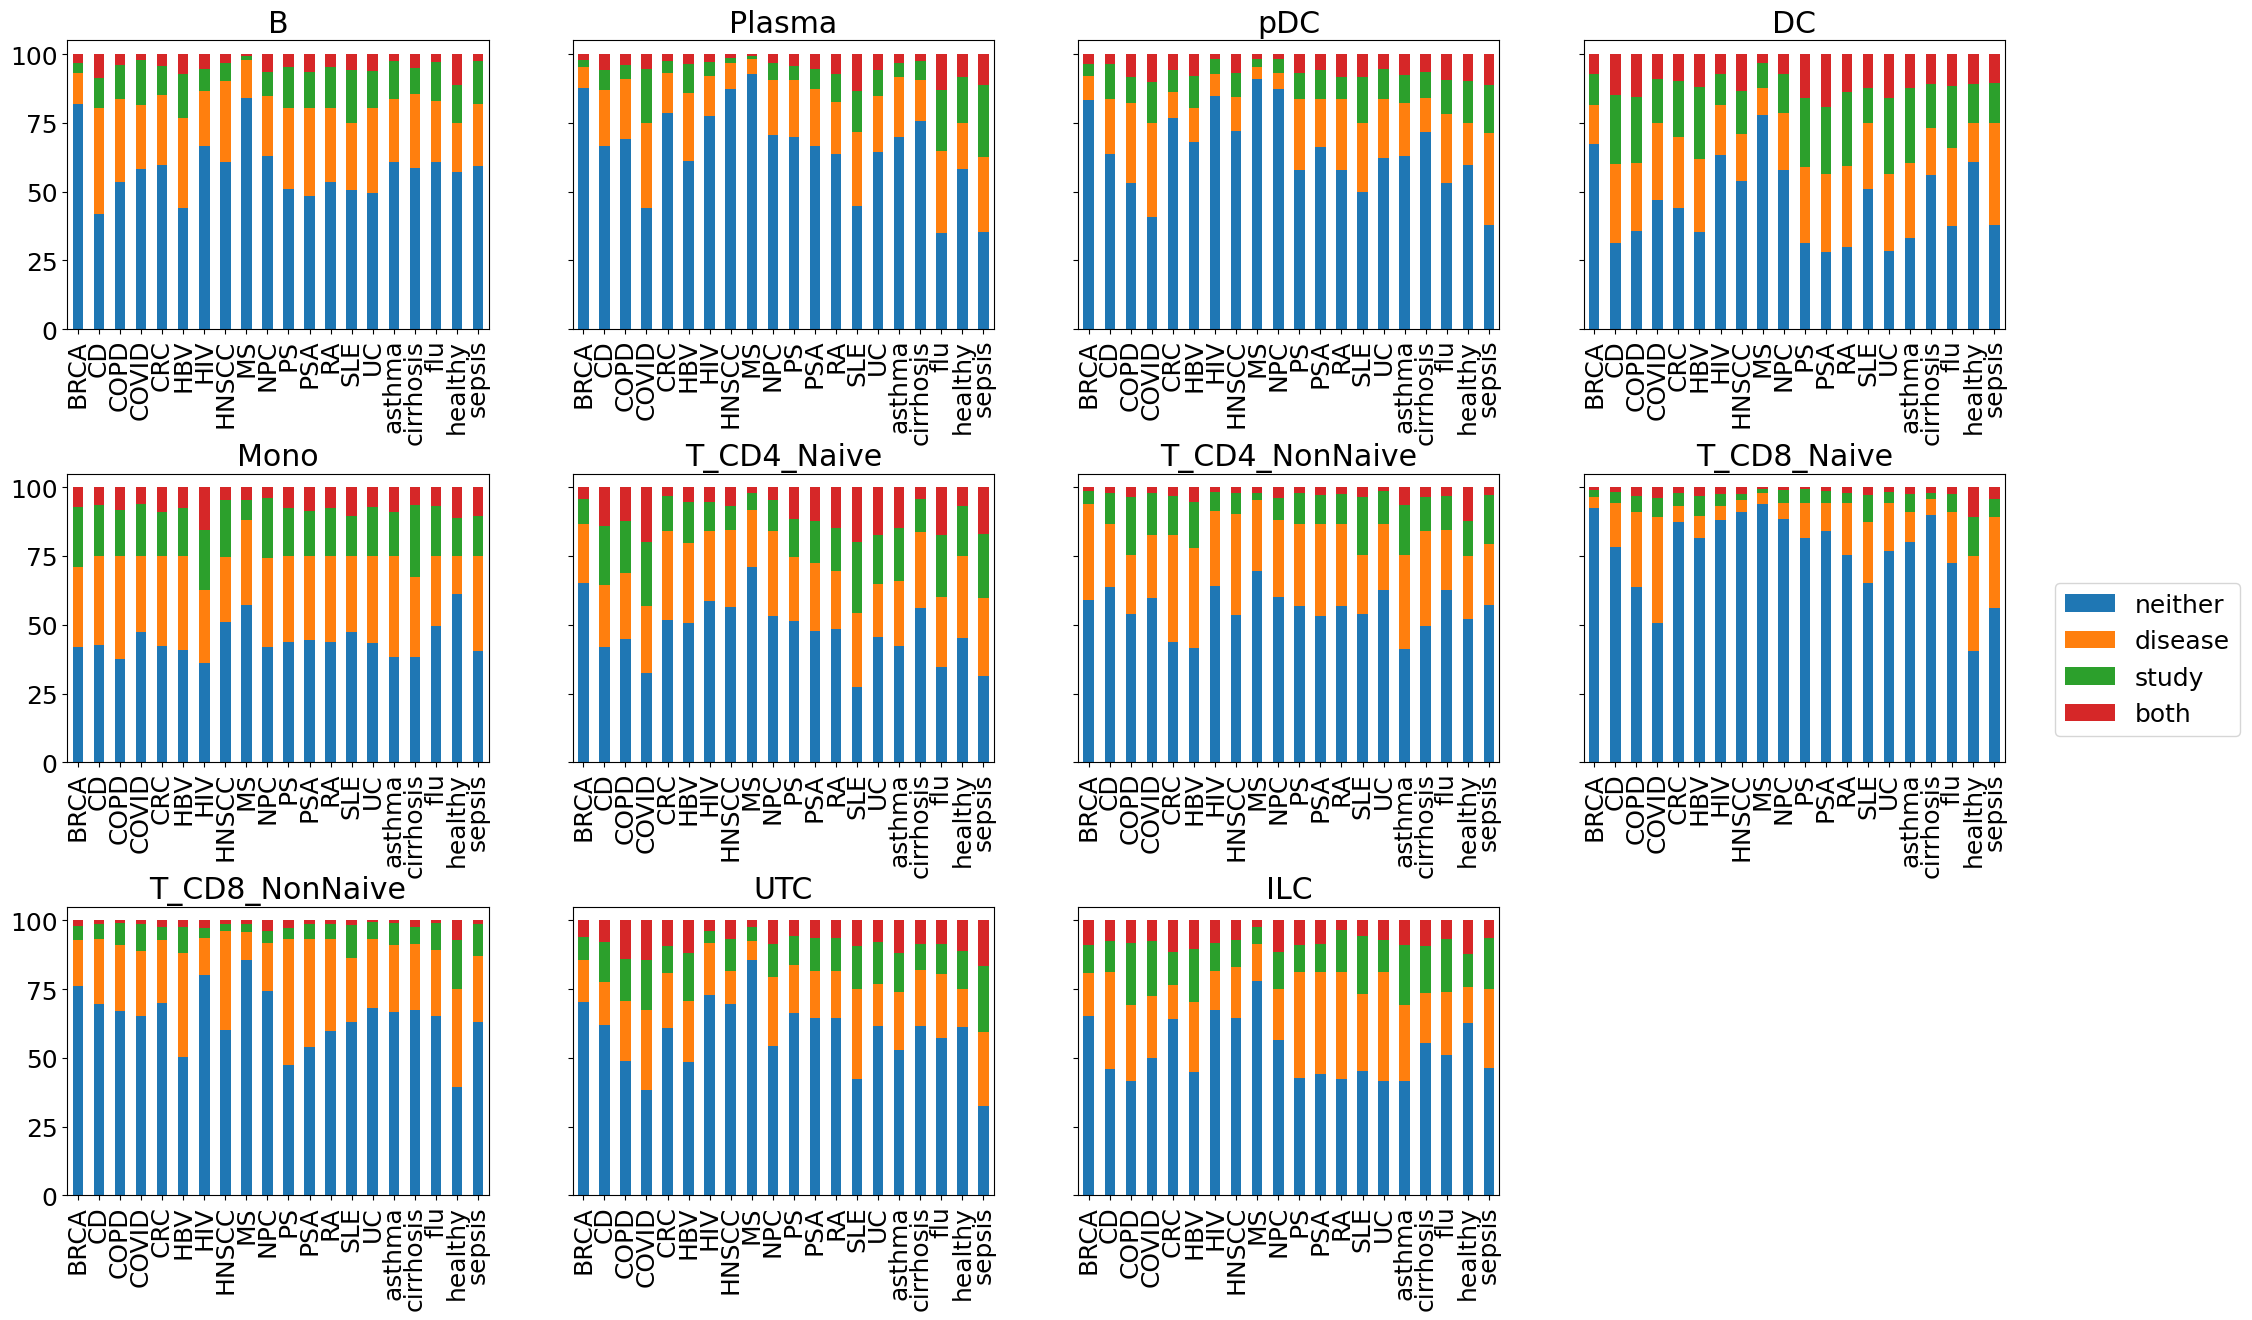

In [13]:
## USED: Per cell type, ratio of genes that have non-zero dSHAP vs non-zero sSHAP values, vs neither vs both, split by disease
matplotlib.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = '18'

fig, axs = plt.subplots(3, 4, figsize=(25, 15), sharex=False, sharey=True)
axs = np.array(axs).flatten()
# plt.suptitle("Per cell type SHAP value distribution", fontsize=18, y=0.95)

for cell_type, ax in zip(CELL_TYPES, axs):

    df_per_cell_type = pd.DataFrame({'gene_group': ['neither', 'disease', 'study', 'both']})       
    diseases = shap_disease_per_cell_type[cell_type].columns
    for disease in diseases:
    
        df_1 = study_shap_per_disease[cell_type][disease]
        df_2 = shap_disease_per_cell_type[cell_type][disease]
        df_match  = pd.concat([df_1, df_2], keys=['studySHAP', 'diseaseSHAP'], axis = 1, ignore_index=False, join = 'inner')

        first_quantile_st = np.quantile(df_1, 0.25)
        first_quantile_dis = np.quantile(df_2, 0.25)
        
        plot_df = df_match[['studySHAP','diseaseSHAP']]
        plot_df['studySHAP'].values[plot_df['studySHAP'].values > first_quantile_st] = 2
        plot_df['studySHAP'].values[plot_df['studySHAP'].values <= first_quantile_st] = 0
        plot_df['diseaseSHAP'].values[plot_df['diseaseSHAP'].values > first_quantile_dis] = 1
        plot_df['diseaseSHAP'].values[plot_df['diseaseSHAP'].values <= first_quantile_dis] = 0
        plot_df['gene_group'] = plot_df['studySHAP'] + plot_df['diseaseSHAP']
        
        data = plot_df['gene_group'].value_counts().reset_index().sort_values('gene_group')
        total = data['count'].sum()
        data['ratio'] = data['count'] *100/total
        data['gene_group'] = data['gene_group'].replace({0:'neither', 1:'disease', 2:'study', 3:'both'})
        df_per_cell_type[disease] = data['ratio']
    
    df_per_cell_type = df_per_cell_type.T
    df_per_cell_type.columns = df_per_cell_type.iloc[0]
    df_per_cell_type = df_per_cell_type[1:]
    df_per_cell_type['Disease'] = df_per_cell_type.index
    
    df_per_cell_type.plot(ax=ax, x='Disease', kind='bar', stacked=True, title=cell_type)

    ax.get_legend().remove()
    ax.set_xlabel("")

fig.delaxes(axs[-1])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')


plt.subplots_adjust(hspace=0.5)
plt.show()

fig.savefig(fname = here('03_downstream_analysis/08_gene_importance/studyID_filtered_SHAP/results/SHAP_value_distr_barplot_across_celltypes/ratio_quantile.svg'), bbox_inches='tight')


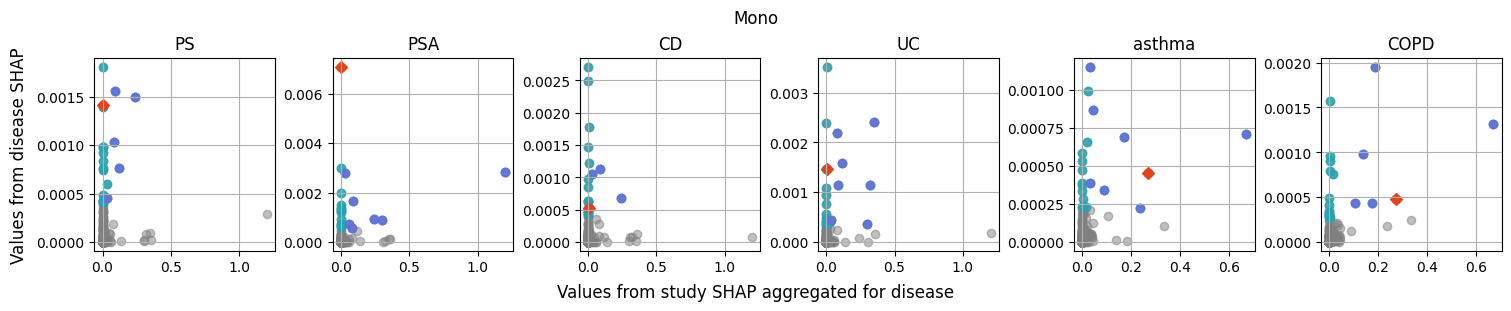

In [15]:
## USED: Distribution of raw dSHAP vs sSHAP values per cell type, split by disease. Top 20 genes by dSHAP annotated, of these the ones within top 20 sSHAP annotated differently. Genes of interest marked.

# Option 1
gene_name = 'CYBA'
diseases = ['PS', 'PSA', 'CD', 'UC', 'asthma', 'COPD']
cell_type = 'Mono'
# Option 2
# gene_name = 'IFITM1'
# diseases = ['cirrhosis', 'asthma', 'COPD']
# cell_type = 'T_CD4_NonNaive'
# cell_type = 'ILC'


# fig, axs = plt.subplots(1, 4, figsize=(10, 3), sharex=False, sharey=False, constrained_layout=True)
fig, axs = plt.subplots(1, 6, figsize=(15, 3), sharex=False, sharey=False, constrained_layout=True)
# fig, axs = plt.subplots(1, 3, figsize=(7.5, 3), sharex=False, sharey=False, constrained_layout=True)
axs = np.array(axs).flatten()
for disease, ax in zip(diseases, axs):

    df_1 = study_shap_per_disease[cell_type][disease]
    df_2 = shap_disease_per_cell_type[cell_type][disease]
    df_match  = pd.concat([df_1, df_2], keys=['studySHAP', 'diseaseSHAP'], axis = 1, ignore_index=False, join = 'inner')

    plt_title = disease

    imp_genes_dis = df_2.nlargest(20).index
    imp_genes_st = df_1.nlargest(20).index
    rel_imp_genes_st = imp_genes_st.intersection(imp_genes_dis)

    df_filt_dis = df_match.loc[imp_genes_dis, :]
    df_filt_st = df_filt_dis.loc[rel_imp_genes_st, :]
    
    df_mark = df_match.loc[[gene_name], :]

    ax.scatter(df_match['studySHAP'].values, df_match['diseaseSHAP'].values, alpha=0.5, color = 'grey')
    ax.scatter(df_filt_dis['studySHAP'].values, df_filt_dis['diseaseSHAP'].values, alpha=0.8, color = '#22a6b3')
    ax.scatter(df_filt_st['studySHAP'].values, df_filt_st['diseaseSHAP'].values, alpha=0.8,color = '#686de0')
    ax.scatter(df_mark['studySHAP'].values, df_mark['diseaseSHAP'].values, alpha=1, color = '#e84118', marker = 'D')  
    ax.set_title(plt_title)
    ax.grid(True)

fig.suptitle(cell_type)
fig.supxlabel('Values from study SHAP aggregated for disease')
fig.supylabel('Values from disease SHAP')
matplotlib.rcParams["svg.fonttype"] = 'none'
plt.savefig(fname = here(f'03_downstream_analysis/08_gene_importance/studyID_filtered_SHAP/results/scatter_by_celltype_filtered_genes_marked_goi/{cell_type}_{gene_name}.pdf'))

In [13]:
## USED: Save important genes to list (top 20 by dSHAP). If genes also in top 20 by sSHAP add separate column. Adjust to trim dSHAP and sSHAP at exactly zero.

genes_to_save = dict()

diseases = shap_disease_per_cell_type[cell_type].columns

with pd.ExcelWriter('./results/gene_list/SHAP_gene_list.xlsx') as writer: 
    for cell_type in  tqdm(CELL_TYPES):
        
        diseases = shap_disease_per_cell_type[cell_type].columns
        df = {}
        for disease in diseases:
        
            df_1 = study_shap_per_disease[cell_type][disease]
            df_2 = shap_disease_per_cell_type[cell_type][disease]
            df_match  = pd.concat([df_1, df_2], keys=['studySHAP', 'diseaseSHAP'], axis = 1, ignore_index=False, join = 'inner')
    
            imp_genes_dis = np.trim_zeros(df_2.nlargest(20).sort_values(ascending = False))
            imp_genes_dis = imp_genes_dis.index
            imp_genes_st = np.trim_zeros(df_1.nlargest(20))
            imp_genes_st = imp_genes_st.index
            
            rel_imp_genes_st = imp_genes_st.intersection(imp_genes_dis)            
            col_2 = np.array(['yes' if var in rel_imp_genes_st.values else 'no' for var in imp_genes_dis])

            # to pad df in case less than 20 genes in some columns
            df[(disease, 'Top 20 genes ranked by dSHAP')] = np.pad(imp_genes_dis, (0, 20-len(imp_genes_dis)), constant_values='')
            df[(disease, 'Affected by study batch effect')] = np.pad(col_2, (0, 20-len(col_2)), constant_values='')
    
        pd.DataFrame.from_dict(df).to_excel(writer, sheet_name=cell_type)

  0%|          | 0/11 [00:00<?, ?it/s]